# Volatility Forecasting: Stochastic vs Machine Learning Methods

This notebook details our comparative analysis of classical stochastic volatility models with machine learning approaches for forecasting stock return volatility at multiple horizons.

We consider:

- **EWMA** (Exponentially Weighted Moving Average)
- **GARCH(1,1)**
- **GJR-GARCH(1,1)** (captures leverage effect)
- **Pure LSTM** (pure deep learning model)
- **Hybrid LSTM** (LSTM correcting GJR forecasts)

We use daily log returns of a single equity (here Microsoft) and evaluate multi-day ahead volatility forecasts (e.g. 5, 20, 25-day horizons) using the **QLIKE** loss. The notebook is structured as a research-style report with:

1. Justification of **QLIKE** over MSE/RMSE for volatility forecast evaluation  
2. Definition of **realised volatility** using daily data and justification of **log returns**  
3. EWMA model, tuning $\lambda$, and selecting $\lambda \epsilon \{0.96, 0.95, 0.95\}$  
4. GARCH(1,1) and GJR-GARCH(1,1)  
5. Pure LSTM and Hybrid LSTM models  
6. Final comparison: QLIKE table and a single plot with all models



## 1. Forecast Loss: Why QLIKE Instead of MSE/RMSE?

Let $\hat{h}_t$ be a forecast of variance at time $t$ and $\tilde{\sigma}_t^2$ be a proxy for realised variance (e.g. from squared or realised returns). The **QLIKE** loss for a single forecast is then defined as:

$$
\text{QLIKE}_t(\hat{h}_t, \tilde{\sigma}_t^2)
= \frac{\tilde{\sigma}_t^2}{\hat{h}_t} - \ln\left(\frac{\tilde{\sigma}_t^2}{\hat{h}_t}\right) - 1.
$$

We use average QLIKE over all forecast points as our main evaluation metric. Reasons:

- **Robust to noisy volatility proxies.** In practice $\tilde{\sigma}_t^2$ is measured with error (e.g. daily squared returns or low-frequency realised variance). [Patton (2011)](https://public.econ.duke.edu/~ap172/Patton_robust_JoE_forthcoming.pdf) shows that, under noisy volatility proxies, only **MSE and QLIKE** yield correct model rankings in expectation.
- **Penalises under-prediction of volatility.** QLIKE grows quickly when the forecast variance is too small relative to realised variance. This is desirable in risk management, where underestimating volatility is more costly than overestimating it.
- **Standard in volatility forecast comparisons.** Many empirical studies of GARCH-type and realised volatility models use QLIKE as their primary loss, precisely because it handles proxy noise better than alternatives like MAE or RMSE.

We therefore use **QLIKE** to tune model hyper-parameters (e.g. EWMA $\lambda$) and to compare out-of-sample forecasts for all models.


## 2. Data, Log Returns, and Realised Volatility

We work with **daily log returns** defined as

$$
r_t = \ln\left(\frac{S_t}{S_{t-1}}\right),
$$

where $S_t$ is the adjusted closing price. Log returns are standard in volatility modelling because they are additive over time.

Ideally, **realised volatility** would be computed from high-frequency intraday returns:

$$
\tilde{\sigma}_t^2 = \sum_{i=1}^M r_{t,i}^2,
$$

where $r_{t,i}$ are intraday returns within day $t$. Without intraday data, we use a heuristic proxy based on daily returns:

- For horizon $h$, we define **forward-looking realised variance** at time $t$ as

$$
\tilde{\sigma}_{t,h}^2
= \frac{1}{h} \sum_{i=1}^{h} r_{t+i}^2.
$$

This is the average of the next $h$ daily squared returns. We use this estimate as our forecast target given that it is less noisy than daily squared returns.

All models will produce a forecast of $\tilde{\sigma}_{t,h}^2$ and we will compare these forecasts using QLIKE.


## Imports, constrants, helpers

In [18]:
# ==========================
# Imports and global config
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

!pip install arch --quiet
from arch import arch_model

# ------------------------
# Helper: Seed Function for reproducability
# ------------------------
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# If you want to use the LSTM sections, you need TensorFlow / Keras:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import StandardScaler
    TF_AVAILABLE = True
    set_seeds()
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow / scikit-learn not found. LSTM sections will need these installed.")

plt.rcParams["figure.figsize"] = (10, 5)

# Horizons we will use throughout
HORIZONS = [5, 20, 25]

# ------------------------
# Helper: QLIKE loss
# ------------------------
def qlike_loss(realized_var, forecast_var, eps=1e-12):
    """
    Compute mean QLIKE loss: E[ RV/hv - log(RV/hv) - 1 ].

    realized_var, forecast_var: 1D arrays or pd.Series of same length.
    """
    realized_var = np.asarray(realized_var) 
    forecast_var = np.asarray(forecast_var)
    ratio = (realized_var + eps) / (forecast_var + eps)
    return np.mean(ratio - np.log(ratio) - 1.0)

# ------------------------
# Helper: forward realised variance
# ------------------------
def forward_realized_variance(returns, horizon):
    """
    For each time t, compute forward h-day realised variance:
    RV_{t,h} = mean of r_{t+1}^2, ..., r_{t+h}^2.
    Returned series is aligned with time t (same index as returns).
    """
    sq = returns**2
    rv = sq.rolling(window=horizon).mean().shift(-horizon)
    return rv

## Load prices & log returns

Ticker          MSFT
Date                
2015-01-05 -0.009238
2015-01-06 -0.014786
2015-01-07  0.012625
2015-01-08  0.028994
2015-01-09 -0.008441


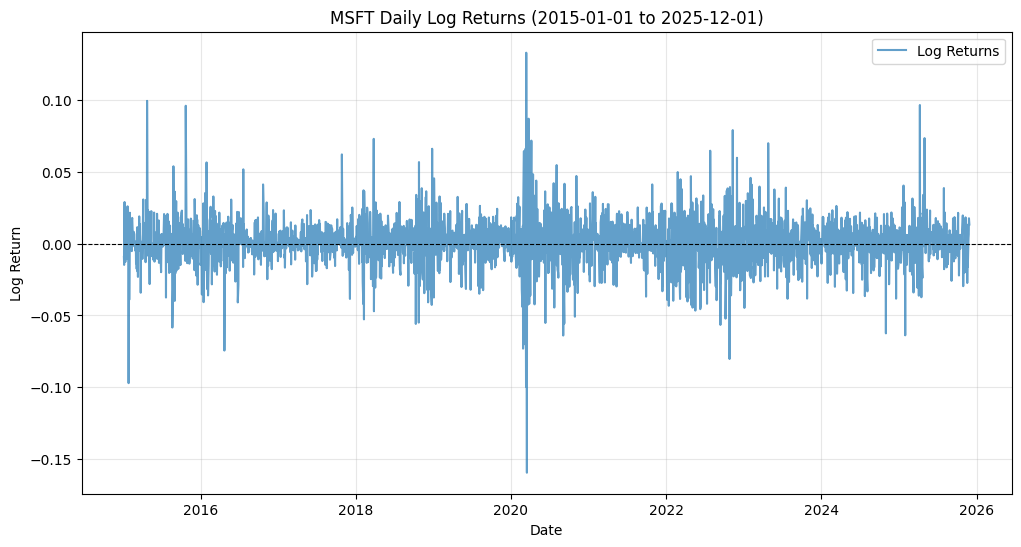

In [2]:
# ==========================
# Data loading and log returns
# ==========================
import yfinance as yf

TICKER = "MSFT"
START_DATE = "2015-01-01"
END_DATE   = "2025-12-01"

prices = yf.download(TICKER, start=START_DATE, end=END_DATE,
                     auto_adjust=True, progress=False)["Close"]
returns = np.log(prices / prices.shift(1)).dropna()
returns.name = "log_return"

print(returns.head())

# plot returns and highlight volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns.values, alpha=0.7, label='Log Returns')
plt.title(f"{TICKER} Daily Log Returns ({START_DATE} to {END_DATE})")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # Adds a line at 0 for reference
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("MSFT_log_returns.png")
plt.show()

## Train/ Test split

In [3]:
# --------------------------
# Train / test split
# --------------------------
train_end = "2021-12-31"  # you can change this if you want a different cut
train_returns = returns.loc[:train_end]
test_returns  = returns.loc[train_end:]

print(f"Train samples: {len(train_returns)}, Test samples: {len(test_returns)}")

Train samples: 1762, Test samples: 982


 # Exponentially Weighted Moving Average (EWMA)


## 3. EWMA Volatility Model and Tuning $\lambda$ (Train/Validation/Test)

The **Exponentially Weighted Moving Average (EWMA)** model updates conditional variance using the below recursive formula:

$$
\sigma_t^2 = \lambda\,\sigma_{t-1}^2 + (1-\lambda)\, r_{t-1}^2,
$$

where $0 < \lambda < 1$ controls how quickly past shocks are discounted:

- Large $\lambda$ → very persistent volatility (slow decay of shocks)  
- Small $\lambda$ → more reactive but noisier volatility estimates  

[RiskMetrics](https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a) popularised $\lambda = 0.94$ for daily equity returns, based on a large cross-section of assets and an in-sample error minimisation procedure on historical data. Rather than fixing this “universal” value, we **estimate $\lambda$ from the data for our specific asset and horizon**, following the approach of [Bollen (2015)](https://www.researchgate.net/publication/282240091_What_should_the_value_of_lambda_be_in_the_exponentially_weighted_moving_average_volatility_model) and related work that treats $\lambda$ as a parameter to be estimated by minimising a forecast loss on a pre-test sample.

We use a simple **train/test split**, which is standard in volatility-forecasting studies:  

- **Train period**: used to choose $\lambda$ by minimising **QLIKE**.  
- **Test period**: completely unseen when choosing $\lambda$, used once to assess performance of the chosen $\lambda^\star$.  

EWMA has **only one scalar parameter**, hence, using the full pre-test sample to estimate $\lambda$ could provide a more stable estimate of the optimal decay, while still preserving a clean out-of-sample test window.

The procedure for each horizon $h$ (e.g. 5, 20, 25 days) is the following:

1. On the **train** data, for each candidate $\lambda$ in a grid (e.g. 0.80-0.99),  
   - compute the EWMA variance series,  
   - treat $\sigma_t^2$ as a forecast of the forward $h$-day realised variance,  
   - compute the mean **QLIKE** loss.
2. Plot **QLIKE vs $\lambda$** of the train set and pick  
   $$
   \lambda^\star = \arg\min_{\lambda} \text{QLIKE}_\text{train}(\lambda).
   $$
3. With this single $\lambda^\star$, recompute EWMA on the **test** window and report the **test QLIKE**.


## EWMA functions & λ grid search

In [4]:
# ==========================
# EWMA: implementation and QLIKE helper (fixed)
# ==========================

def ewma_variance(returns, lam):
    """
    Compute EWMA variance series given returns and decay factor lam.
    Works if 'returns' is a Series or a 1-column DataFrame.
    """
    # Drop NaNs and squeeze to a Series if it's a 1-col DataFrame
    returns = returns.dropna()
    if isinstance(returns, pd.DataFrame):
        returns = returns.iloc[:, 0]

    n = len(returns)
    var = np.empty(n)

    # initialise with first squared return as a scalar
    first_ret = float(returns.iloc[0])
    var[0] = first_ret ** 2

    for t in range(1, n):
        r_prev = float(returns.iloc[t-1])
        var[t] = lam * var[t-1] + (1.0 - lam) * (r_prev ** 2)

    return pd.Series(var, index=returns.index, name=f"ewma_var_{lam:.2f}")


def ewma_forward_forecast_qlike(returns, horizon, lam):
    """
    Given returns, EWMA lambda, and horizon h:
    - compute daily EWMA variance
    - treat var_t as forecast for forward h-day variance at time t
    - compare to realised forward variance using QLIKE
    """
    # Make sure returns is a Series
    if isinstance(returns, pd.DataFrame):
        returns = returns.iloc[:, 0]

    ewma_var = ewma_variance(returns, lam)
    rv_forward = forward_realized_variance(returns, horizon)

    # Ensure simple column names, not MultiIndex
    df = pd.DataFrame({
        "realized_var": rv_forward,
        "forecast_var": ewma_var,
    }).dropna()

    return qlike_loss(df["realized_var"], df["forecast_var"])


# --------------------------
# Grid search over lambda on TRAIN data
# --------------------------
lambda_grid = np.arange(0.80, 0.991, 0.01)
ewma_qlike_table = pd.DataFrame(index=lambda_grid, columns=HORIZONS, dtype=float)

for lam in lambda_grid:
    for h in HORIZONS:
        ewma_qlike_table.loc[lam, h] = ewma_forward_forecast_qlike(
            train_returns, horizon=h, lam=lam
        )


## λ table & best λ per horizon

In [5]:
# λ table & best λ per horizon (TRAIN) + train/test summary

# Look at first few rows of the train QLIKE table
display(ewma_qlike_table.round(6))

best_lambdas = {}
summary_rows = []

for h in HORIZONS:
    # best λ on TRAIN for this horizon
    best_l = ewma_qlike_table[h].idxmin()
    best_lambdas[h] = best_l
    train_min = ewma_qlike_table[h].min()

    # QLIKE on TEST using this horizon-specific λ*
    test_q = ewma_forward_forecast_qlike(test_returns, horizon=h, lam=best_l)

    summary_rows.append({
        "horizon": h,
        "lambda_star": best_l,
        "QLIKE_train": train_min,
        "QLIKE_test": test_q,
    })

    print(f"[H = {h:2d}] λ*_h = {best_l:.2f} | "
          f"QLIKE_train = {train_min:.6f} | QLIKE_test = {test_q:.6f}")

# Nice summary table
ewma_summary = pd.DataFrame(summary_rows).set_index("horizon")
print("\nEWMA λ* and QLIKE summary (per horizon):")
display(ewma_summary.round(6))


,5,20,25
0.80,0.899836,0.736738,0.722198
0.81,0.883722,0.713692,0.698846
0.82,0.867577,0.691131,0.676129
0.83,0.851337,0.669085,0.654085
0.84,0.834950,0.647600,0.632768
0.85,0.818390,0.626750,0.612254
0.86,0.801675,0.606644,0.592647
0.87,0.784884,0.587428,0.574082
0.88,0.768168,0.569293,0.556733
0.89,0.751763,0.552476,0.540811


[H =  5] λ*_h = 0.96 | QLIKE_train = 0.680244 | QLIKE_test = 0.422175
[H = 20] λ*_h = 0.95 | QLIKE_train = 0.497432 | QLIKE_test = 0.204881
[H = 25] λ*_h = 0.95 | QLIKE_train = 0.491686 | QLIKE_test = 0.186642

EWMA λ* and QLIKE summary (per horizon):


,lambda_star,QLIKE_train,QLIKE_test
horizon,,,
5,0.96,0.680244,0.422175
20,0.95,0.497432,0.204881
25,0.95,0.491686,0.186642


## QLIKE vs λ graphs

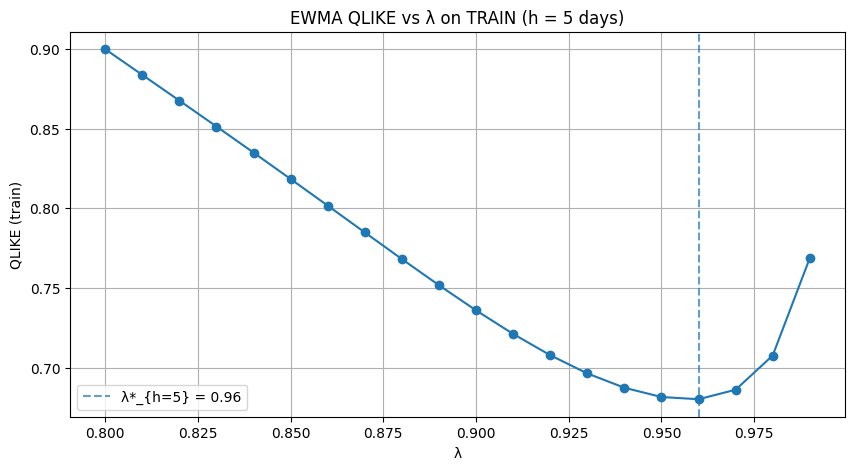

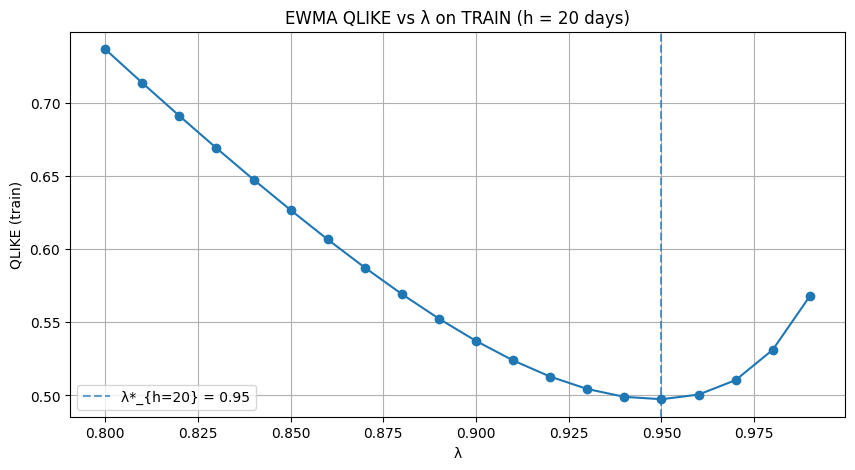

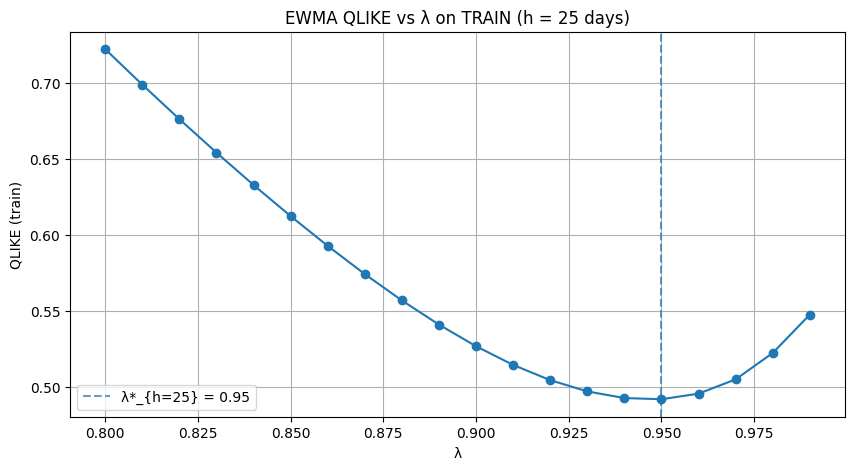

In [6]:
# QLIKE vs λ graphs on TRAIN, with horizon-specific λ*_h marked

for h in HORIZONS:
    plt.figure()
    plt.plot(ewma_qlike_table.index, ewma_qlike_table[h], marker="o")

    # vertical line at λ*_h for this horizon
    best_l = best_lambdas[h]
    plt.axvline(best_l, linestyle="--", alpha=0.7,
                label=fr"λ*_{{h={h}}} = {best_l:.2f}")

    plt.title(f"EWMA QLIKE vs λ on TRAIN (h = {h} days)")
    plt.xlabel("λ")
    plt.ylabel("QLIKE (train)")
    plt.grid(True)
    plt.legend()
    plt.savefig(f'EWMA_QLIKE_h={h}.png')
    # plt.close()
    plt.show()



## Choice of $\lambda$ for EWMA

From the grid search, the optimal $\lambda$ values for 5, 20 and 25-day horizons are **0.96**, **0.95**, and **0.95**, respectively.

## Final EWMA variance series on test returns

In [7]:
# ==========================
# We use the horizon-specific EWMA lambdas (lambda_star) found on TRAIN
# ==========================

LAMBDA_STARS = best_lambdas

ewma_var_full_by_h = {
    h: ewma_variance(test_returns, LAMBDA_STARS[h]).rename(f"EWMA_var_lambdaStar_h{h}")
    for h in HORIZONS
}

pd.concat(ewma_var_full_by_h, axis=1).head()

,5,20,25
Date,,,
2021-12-31,0.000079,0.000079,0.000079
2022-01-03,0.000079,0.000079,0.000079
2022-01-04,0.000077,0.000076,0.000076
2022-01-05,0.000085,0.000087,0.000087
2022-01-06,0.000143,0.000159,0.000159


## EWMA Forcasting wrapper

In [8]:
# ==========================
# Forecasting wrappers
# ==========================

def ewma_forecasts_for_horizon(returns, horizon, lam):
    """
    Build a DataFrame with realized_var and forecast_var for EWMA,
    for a given horizon and lambda, on the provided returns.
    """
    # Ensure returns is a Series (handle 1-col DataFrame)
    if isinstance(returns, pd.DataFrame):
        returns_series = returns.iloc[:, 0]
    else:
        returns_series = returns

    ewma_var = ewma_variance(returns_series, lam)
    rv_forward = forward_realized_variance(returns_series, horizon)

    df = pd.DataFrame(
        {
            "realized_var": rv_forward,
            "forecast_var": ewma_var,
        }
    ).dropna()

    return df

# GARCH(1,1) Model


## 4. GARCH(1,1) Model

The **GARCH(1,1)** model specifies conditional variance as

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2,
$$

with $\omega > 0$, $\alpha \ge 0$, $\beta \ge 0$ and typically $\alpha + \beta < 1$ for stationarity.

- $\alpha$ captures the impact of the most recent shock (ARCH effect).
- $\beta$ captures persistence of past volatility (GARCH effect).
- The unconditional variance is $\omega / (1 - \alpha - \beta)$.

GARCH(1,1) is a standard benchmark model: Hansen & Lunde (2005) show that, in many cases, more complex ARCH/GARCH variants do **not** significantly outperform GARCH(1,1) out-of-sample.

We will fit a GARCH(1,1) to returns and generate rolling forecasts of variance (more details on selection in the Appendix).


### GARCH(1,1) and GJR-GARCH helpers (with simple rescaling)

The code below defines two helper functions:

- `fit_garch11` fits a standard GARCH(1,1) model to a single return series.
- `rolling_garch_forecasts` produces **rolling one-step-ahead variance forecasts**
  for both GARCH(1,1) and GJR-GARCH(1,1) over an expanding window.

For each evaluation date $t$:

1. We take all returns up to $t - 1$ as the estimation window.
2. We fit either  
   - a GARCH(1,1) model, or  
   - a GJR-GARCH(1,1) model (with an extra term to capture leverage effects).
3. We obtain the one-step-ahead conditional variance forecast $\hat{\sigma}_t^2$.
4. We treat this daily variance as the model’s forecast for the corresponding
   forward realised variance used in the QLIKE loss.

To improve numerical stability and avoid “poorly scaled” warnings, we apply a
simple **rescaling** inside the model:

- We fit GARCH/GJR to scaled returns
  $r_t^{(\text{scaled})} = \text{scale} \cdot r_t$ with $\text{scale} = 100$.
- The model then forecasts the variance of the scaled series,
  $\sigma_{t,\text{scaled}}^2 = \mathrm{Var}\big(r_t^{(\text{scaled})}\big)$.
- Since $\mathrm{Var}(\text{scale} \cdot r_t) = \text{scale}^2 \,\mathrm{Var}(r_t)$,
  we recover the variance in the original units by dividing by $\text{scale}^2$:
  $\sigma_t^2 = \sigma_{t,\text{scaled}}^2 / \text{scale}^2$.

In other words, the rescaling is just a change of units (fractions vs percentages):
it stabilises the optimisation but **does not change the economic meaning of the
forecast**. The final `forecast_var` series is on the same scale as the realised
variance and the other models (EWMA, LSTM, hybrid) used in the rest of the notebook.

We also explicitly handle the case where the GARCH optimisation **fails to converge**
for a given date $t$. If the fitted model reports that it has not converged, we
treat the corresponding parameters as unreliable and do not use the new forecast
from that fit. Instead, we simply reuse the last good variance forecast
$\hat{\sigma}_{t-1}^2$ and carry it forward. If there is no previous forecast yet
(very early in the sample), we skip that date. This “no-update on error” rule
prevents a single failed optimisation from producing an artificial volatility spike
that would distort both the plots and the QLIKE evaluation.


In [9]:
# ==========================
# GARCH(1,1) and GJR-GARCH helpers
# ==========================

def fit_garch11(series):
    """Fit GARCH(1,1) on In-Sample data."""
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]
    
    # Scale data for numerical stability
    am = arch_model(series * 100, vol="GARCH", p=1, q=1, 
                    mean="constant", dist="normal", rescale=False)
    res = am.fit(disp="off")
    return res

def fit_gjrgarch11(series):
    """Fit GJR-GARCH(1,1) on In-Sample data."""
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]
        
    # o=1 enables the leverage effect (GJR)
    am = arch_model(series * 100, vol="GARCH", p=1, o=1, q=1, 
                    mean="constant", dist="normal", rescale=False)
    res = am.fit(disp="off")
    return res

def rolling_garch_forecasts(returns, horizon, model_type="GARCH", params=None):
    # 1. Setup Data & Neutralize Timezones (CRITICAL STEP)
    returns_series = returns.iloc[:, 0] if isinstance(returns, pd.DataFrame) else returns
    returns_series = returns_series.dropna()
    
    # Force Timezone-Naive (Removes UTC offset if present)
    if returns_series.index.tz is not None:
        returns_series.index = returns_series.index.tz_localize(None)

    # 2. Prepare Target on the Naive Series
    rv_forward = forward_realized_variance(returns_series, horizon).dropna()
    
    scale = 100

    # Fixed Parameters
    if params is not None:
        # Define model on the FULL History provided
        if model_type == "GARCH":
            am = arch_model(returns_series * scale, vol="GARCH", p=1, q=1, 
                            mean="constant", dist="normal", rescale=False)
        elif model_type == "GJR":
            am = arch_model(returns_series * scale, vol="GARCH", p=1, o=1, q=1, 
                            mean="constant", dist="normal", rescale=False)
        
        # Lock Parameters
        res = am.fix(params)
        
        # Forecast
        # Note: 'start=0' ensures we force forecasts for the entire series
        fcast = res.forecast(horizon=horizon, start=0, reindex=False)
        
        # Calculate Horizon Mean
        avg_forecast_scaled = fcast.variance.mean(axis=1)
        forecast_var = avg_forecast_scaled / (scale ** 2)

    # Rolling Re-estimation
    else:
        valid_idx = rv_forward.index
        forecast_var = pd.Series(index=valid_idx, dtype=float)
        last_good_sigma2 = None

        for t in valid_idx:
            est_series = returns_series.loc[:t].iloc[:-1]
            if len(est_series) < 1: continue

            est_scaled = est_series * scale

            if model_type == "GARCH":
                am = arch_model(est_scaled, vol="GARCH", p=1, q=1, 
                                mean="constant", dist="normal", rescale=False)
            elif model_type == "GJR":
                am = arch_model(est_scaled, vol="GARCH", p=1, o=1, q=1, 
                                mean="constant", dist="normal", rescale=False)
            
            res = am.fit(disp="off")

            if not getattr(res, "converged", True):
                if last_good_sigma2 is None: continue
                sigma2_next = last_good_sigma2
            else:
                fcast = res.forecast(horizon=1, reindex=False)
                sigma2_scaled = float(fcast.variance.iloc[-1, 0])
                sigma2_next = sigma2_scaled / (scale ** 2)

            forecast_var.loc[t] = sigma2_next
            last_good_sigma2 = sigma2_next

    # Combine into DataFrame
    df = pd.DataFrame({
        "realized_var": rv_forward,
        "forecast_var": forecast_var,
    }).dropna()

    return df

# GJR-GARCH(1,1) Model

## 5. GJR-GARCH(1,1): Leverage Effect

Equity returns exhibit a **leverage effect**: negative returns tend to increase future volatility more than positive returns of the same magnitude.

The **GJR-GARCH(1,1)** model (Glosten, Jagannathan, Runkle, 1993) extends GARCH by adding an asymmetric term:

$$
\sigma_t^2 = \omega
            + \alpha r_{t-1}^2
            + \gamma r_{t-1}^2 \mathbf{1}_{\{r_{t-1} < 0\}}
            + \beta \sigma_{t-1}^2.
$$

- If $r_{t-1} < 0$, the shock enters with coefficient $\alpha + \gamma$.
- If $r_{t-1} \ge 0$, the shock enters with coefficient $\alpha$.

For stocks, we typically find $\gamma > 0$, confirming that **bad news has a larger impact on volatility**. We will fit a GJR-GARCH(1,1) and compare its forecasts to standard GARCH(1,1).


## Inspect in-sample GARCH & GJR

In [10]:
garch_res = fit_garch11(train_returns)
print("GARCH(1,1) in-sample params:")
print(garch_res.params)

# we scale returns directly by 100 when fitting the GJR-GARCH model
gjr_model = arch_model(train_returns*100, vol="GARCH", p=1, o=1, q=1, mean="constant", dist="normal", rescale=False)
gjr_res = gjr_model.fit(disp="off")
print("\nGJR-GARCH(1,1) in-sample params:")
print(gjr_res.params)

GARCH(1,1) in-sample params:
mu          0.138620
omega       0.262888
alpha[1]    0.211658
beta[1]     0.702987
Name: params, dtype: float64

GJR-GARCH(1,1) in-sample params:
mu          0.110491
omega       0.270437
alpha[1]    0.118179
gamma[1]    0.153760
beta[1]     0.712528
Name: params, dtype: float64


## GARCH and GJR-GARCH Forcasting Wrapper

In [11]:
# ==========================
# Forecasting wrappers
# ==========================

def garch_family_forecasts_for_horizon(returns, horizon, model_type="GARCH", params=None):
    """
    Wrapper to get forecasts. 
    If params are provided, it uses them (Fixed Mode).
    If params are None, it re-estimates (Rolling Mode).
    """
    return rolling_garch_forecasts(returns, horizon, model_type=model_type, params=params)

# Long Short-Term Memory (LSTM) Neural Network


## 6. LSTM Model for Forward-Looking Realised Variance

Deep learning models such as **LSTM (Long Short-Term Memory) networks** can capture nonlinear dynamics and long-range dependencies in time series.

We use an LSTM to directly predict **forward-looking realised variance** over horizon $h$:

$$
\tilde{\sigma}_{t,h}^2 = \frac{1}{h} \sum_{i=1}^{h} r_{t+i}^2.
$$

At each time $t$, the LSTM takes as input a window of past features (returns, squared returns, rolling volatilities) and outputs a forecast of $\tilde{\sigma}_{t,h}^2$.

Key design choices:

- Input features:
  - Last 5 returns $r_{t-1}, \dots, r_{t-5}$
  - Last 5 squared returns $r_{t-1}^2, \dots, r_{t-5}^2$
  - Rolling volatility and variance over windows (5, 10, 22, 50 days)
- Target:
  - Log of forward realised variance (for better scaling), standardised.
- Network:
  - Single LSTM layer + Dropout + Dense head.
- Training:
  - Train on in-sample (e.g. up to 2019), validate on 2020-2021.


## LSTM feature construction

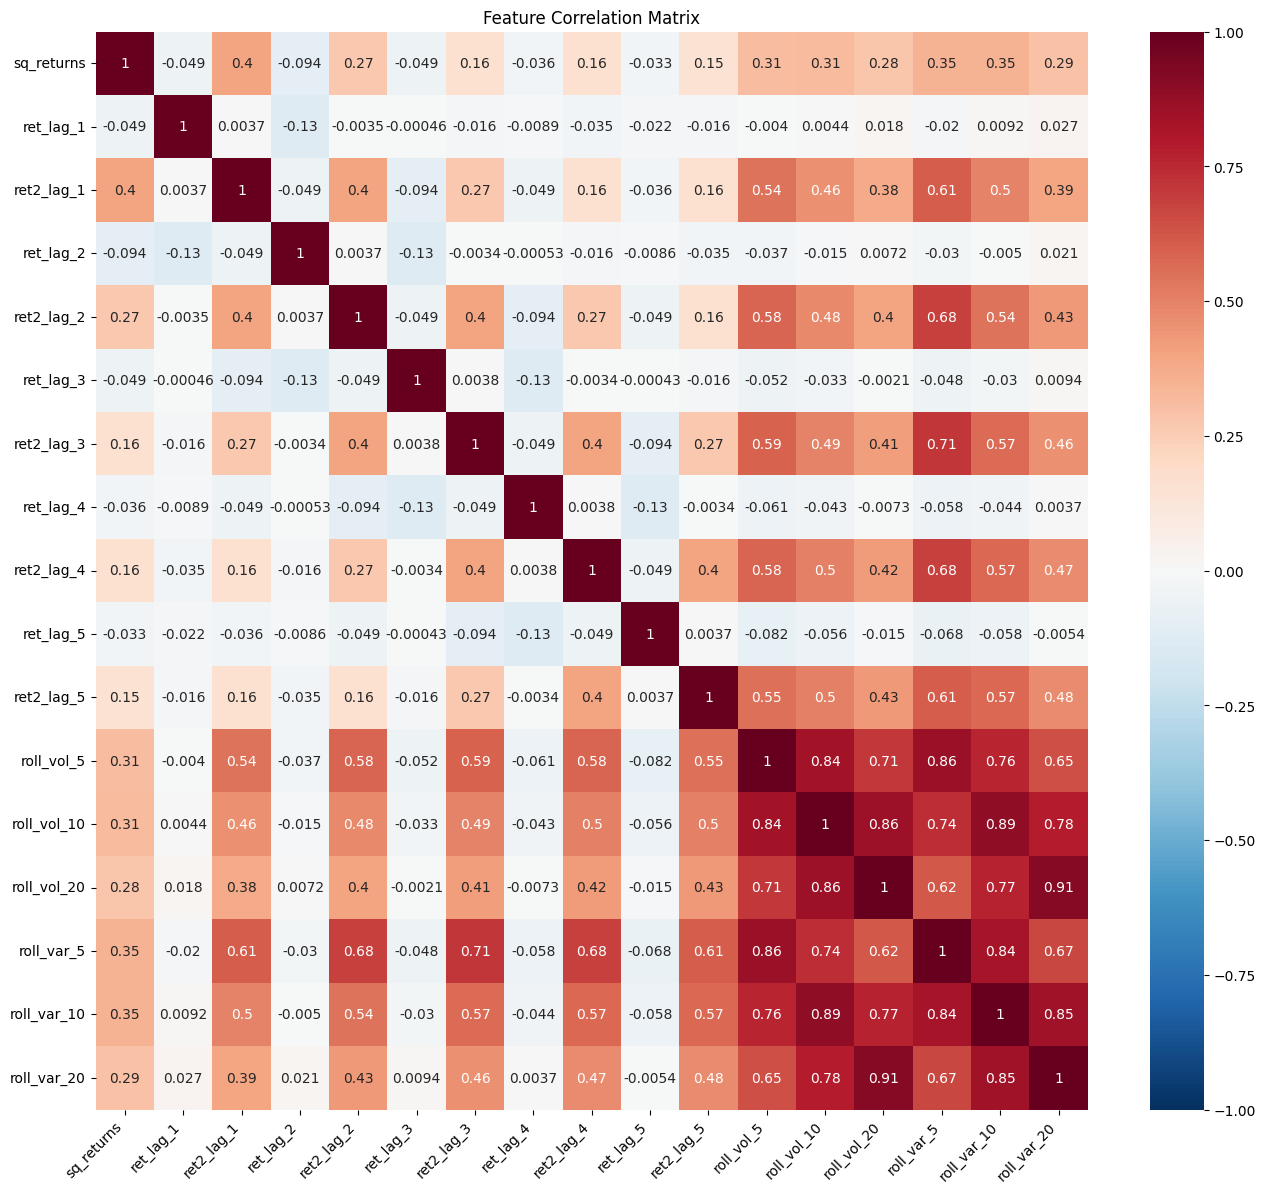

In [12]:
# ==========================
# LSTM feature engineering
# ==========================

def create_lstm_features(returns):
    """
    Create a DataFrame of features for each date t:
      - ret_lag_1..5
      - ret2_lag_1..5
      - roll_vol_5,10,25
      - roll_var_5,10,25
    All lagged so that features at time t use information up to t-1.
    """
    df = pd.DataFrame(index=returns.index)

    df['sq_returns'] = returns**2
    
    for lag in range(1, 6):
        df[f"ret_lag_{lag}"] = returns.shift(lag)
        df[f"ret2_lag_{lag}"] = (returns**2).shift(lag)

    for w in [5, 10, 20]:
        df[f"roll_vol_{w}"] = returns.rolling(window=w).std().shift(1)
    for w in [5, 10, 20]:
        df[f"roll_var_{w}"] = (returns**2).rolling(window=w).mean().shift(1)
    
    return df

lstm_feature_df = create_lstm_features(returns)
lstm_feature_df.head()

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
corr_matrix = lstm_feature_df.corr()

# Create figure
plt.figure(figsize=(16, 14))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# plt.close()
plt.show()

## LSTM helpers (sequences + training)

In [13]:
# ==========================
# LSTM helpers
# ==========================
if TF_AVAILABLE:

    def make_forward_var_target(returns, horizon):
        """
        Forward h-day realised variance target aligned with t.
        """
        return forward_realized_variance(returns, horizon)

    def create_sequences(X, y, lookback):
        """
        Turn feature matrix X (T x d) and target y (T) into sequences:
        - X_seq: (N, lookback, d)
        - y_seq: (N,)
        where element i uses rows [i-lookback, ..., i-1] to predict y[i].
        """
        X_seq, y_seq = [], []
        for i in range(lookback, len(X)):
            X_seq.append(X[i-lookback:i])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)

    def build_lstm_model(input_shape):
        """
        Simple LSTM -> Dropout -> Dense model for volatility forecasting.
        """
        set_seeds(42)
        model = Sequential([
            LSTM(128, input_shape=input_shape, activation="tanh", return_sequences=False),
            Dropout(0.2),
            Dense(128, activation="tanh"),
            Dense(1)  # output: log-variance
        ])
        model.compile(optimizer="adam", loss="mse")
        return model

    def train_lstm_for_horizon(returns, feature_df, horizon, lookback=22):
        """Train LSTM for a given horizon h using 70/30 split for train/val."""
        # Ensure returns is a Series
        returns_series = returns.iloc[:, 0] if isinstance(returns, pd.DataFrame) else returns

        # Build target series (forward h-day realized variance)
        target = make_forward_var_target(returns_series, horizon)
        target = target.copy()
        target.name = "target"
        df = pd.concat([feature_df, target], axis=1).dropna()

        # **Split into 70% in-sample and 30% validation by index position**
        n = len(df)
        n_ins = int(0.8 * n)
        df_ins = df.iloc[:n_ins]
        df_val = df.iloc[n_ins:]
        # Extract features and targets for each segment
        X_ins_raw = df_ins.drop(columns=["target"]).values
        y_ins_raw = df_ins["target"].values
        X_val_raw = df_val.drop(columns=["target"]).values
        y_val_raw = df_val["target"].values

        # Scale features
        X_scaler = StandardScaler()
        X_ins = X_scaler.fit_transform(X_ins_raw)
        X_val = X_scaler.transform(X_val_raw)
        # Log-transform and scale targets
        y_ins_log = np.log(y_ins_raw + 1e-12)
        y_val_log = np.log(y_val_raw + 1e-12)
        y_scaler = StandardScaler()
        y_ins = y_scaler.fit_transform(y_ins_log.reshape(-1, 1)).flatten()
        y_val = y_scaler.transform(y_val_log.reshape(-1, 1)).flatten()

        # Create sequences for LSTM
        X_ins_seq, y_ins_seq = create_sequences(X_ins, y_ins, lookback)
        X_val_seq, y_val_seq = create_sequences(X_val, y_val, lookback)

        # Build & train model with early stopping on validation loss
        model = build_lstm_model(input_shape=(lookback, X_ins_seq.shape[2]))
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
        set_seeds(42)
        model.fit(
            X_ins_seq, y_ins_seq,
            epochs=50,
            batch_size=64,
            validation_data=(X_val_seq, y_val_seq),
            callbacks=[es],
            verbose=0
        )
        return model, X_scaler, y_scaler, lookback
else:
    print("TensorFlow/Keras not available: skipping LSTM helper definitions.")


## LSTM Forcasting Wrapper

In [14]:
# ==========================
# Forecasting wrapper
# ==========================

def lstm_forecasts_for_horizon(returns, feature_df, horizon, model_bundle, lookback):
    """Generate LSTM forecasts for the given horizon on the provided returns DataFrame/Series."""
    model, X_scaler, y_scaler = model_bundle
    # Ensure returns is a Series
    returns_series = returns.iloc[:, 0] if isinstance(returns, pd.DataFrame) else returns

    # Build target (forward realized variance) and align with features
    target = forward_realized_variance(returns_series, horizon)
    target = target.copy()
    target.name = "realized_var"
    df = pd.concat([feature_df, target], axis=1).dropna()
    # **Use the full df (no date slicing)** for forecasting
    df_range = df  # since returns is already the desired segment (e.g., test set)

    X_raw = df_range.drop(columns=["realized_var"]).values
    y_realized = df_range["realized_var"].values
    # Scale features
    X_scaled = X_scaler.transform(X_raw)
    # Create sequences
    X_seq, _ = create_sequences(X_scaled, y_realized, lookback)
    valid_index = df_range.index[lookback:]
    # Predict and invert scaling
    y_pred_scaled = model.predict(X_seq, verbose=0).flatten()
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_pred_var = np.exp(y_pred_log)  # back to variance

    out_df = pd.DataFrame({
        "realized_var": y_realized[lookback:],
        "forecast_var": y_pred_var
    }, index=valid_index)
    return out_df


## Train LSTMs for each horizon

In [19]:
lstm_models = {}
lstm_lookback = 22

if TF_AVAILABLE:
    for h in HORIZONS:
        print(f"Training LSTM for horizon {h} days...")

        model, X_scaler, y_scaler, lb = train_lstm_for_horizon(
            train_returns,
            lstm_feature_df,
            horizon=h,
            lookback=lstm_lookback
        )
        lstm_models[h] = (model, X_scaler, y_scaler)

    print("LSTM training completed.")
else:
    print("Skipping LSTM training (TF not available).")


Training LSTM for horizon 5 days...
Training LSTM for horizon 20 days...
Training LSTM for horizon 25 days...
LSTM training completed.


# Hybrid GJR-GARCH + LSTM Model

## 7. Hybrid Model: GJR-GARCH + LSTM (Multiplicative Correction)

The GJR-GARCH(1,1) model already captures two important features of equity volatility:

- **Volatility clustering** (large shocks followed by large shocks),
- **Leverage effect** (negative returns increase future volatility more than positive returns).

However, GJR-GARCH is still a relatively simple parametric model. To capture additional
nonlinear or regime-dependent structure, we combine it with an LSTM in a **hybrid model**.

For each horizon $h \in \{5, 20, 25\}$ we:

1. Use GJR-GARCH(1,1) to obtain a baseline forecast of variance
   $$
   \hat{\sigma}^{2,\text{GJR}}_{t,h}.
   $$
2. Compute the forward-looking realised variance
   $$
   \tilde{\sigma}^{2}_{t,h}.
   $$
3. Define a multiplicative correction factor
   $$
   \rho_t = \frac{\tilde{\sigma}^{2}_{t,h}}{\hat{\sigma}^{2,\text{GJR}}_{t,h}}.
   $$
4. Train an LSTM to predict the log-ratio
   $$
   y_t = \log \rho_t = \log \tilde{\sigma}^{2}_{t,h}
   - \log \hat{\sigma}^{2,\text{GJR}}_{t,h},
   $$
   using as inputs:
   - the same features as the pure LSTM (lagged returns, rolling volatilities and variances),
   - plus the current GJR forecast.
5. At test time, we form the hybrid forecast
   $$
   \hat{\sigma}^{2,\text{hybrid}}_{t,h}
   = \hat{\rho}_t \cdot \hat{\sigma}^{2,\text{GJR}}_{t,h},
   \qquad
   \hat{\rho}_t = \exp\big(\widehat{\log \rho_t}\big).
   $$

If GJR-GARCH captures almost all the predictable variation in volatility, we expect
$\rho_t \approx 1$ and only small gains from the hybrid. If there are remaining nonlinear
patterns, the LSTM learns these and adjusts the GJR forecasts accordingly.




### 7.1 Hybrid Training Function

The next code block defines the function `train_hybrid_lstm_for_horizon`. For a given horizon $h$ it:

1. Calls the existing GJR wrapper to obtain, for each date,
   - the forward realised variance $\tilde{\sigma}^{2}_{t,h}$,
   - the GJR forecast variance $\hat{\sigma}^{2,\text{GJR}}_{t,h}$.
2. Merges these with the LSTM feature matrix (lags, rolling moments, etc.).
3. Builds the target
   $$
   y_t = \log \tilde{\sigma}^{2}_{t,h}
   - \log \hat{\sigma}^{2,\text{GJR}}_{t,h}.
   $$
4. Splits the data into in-sample and validation periods based on calendar dates.
5. Standardises features and targets.
6. Creates sequences of length `lookback` for the LSTM.
7. Trains an LSTM (with early stopping) to predict the scaled log-ratio.

The function returns the trained model together with the fitted feature and target scalers.


In [ ]:
# ==========================
# 7.1 Hybrid LSTM training (multiplicative correction)
# ==========================

if TF_AVAILABLE:

    def train_hybrid_lstm_for_horizon(returns, base_feature_df, horizon, lookback=10):
        """Train Hybrid LSTM for horizon h using 70/30 split for train/val."""
        # Ensure returns is a Series
        returns_series = returns.iloc[:, 0] if isinstance(returns, pd.DataFrame) else returns

        # Fit GJR on the training data explicitly
        gjr_in_sample = fit_gjrgarch11(returns_series)
        gjr_params = gjr_in_sample.params

        # Compute GJR-GARCH baseline forecasts for this horizon (realized_var and forecast_var)
        gjr_df_full = garch_family_forecasts_for_horizon(
            returns_series, 
            horizon=horizon, 
            model_type="GJR", 
            params=gjr_params
        )
        
        # Merge base features with GJR results and drop NaNs
        df_full = pd.concat([base_feature_df, gjr_df_full], axis=1).dropna()

        # Build target: log ratio = log(realized_var) - log(forecast_var)
        eps = 1e-12
        rv  = np.maximum(df_full["realized_var"].values.astype(float), eps)
        gjr = np.maximum(df_full["forecast_var"].values.astype(float), eps)
        y_raw = np.log(rv / gjr)

        # **Split df_full into 80% in-sample and 20% validation**
        n = len(df_full)
        n_ins = int(0.8 * n)
        df_ins = df_full.iloc[:n_ins]
        df_val = df_full.iloc[n_ins:]
        
        # Split feature arrays and target arrays correspondingly
        X_ins_raw = df_ins.drop(columns=["realized_var", "forecast_var"]).values
        X_val_raw = df_val.drop(columns=["realized_var", "forecast_var"]).values
        y_ins_raw = y_raw[:n_ins]
        y_val_raw = y_raw[n_ins:]

        # Scale features
        X_scaler = StandardScaler()
        X_ins = X_scaler.fit_transform(X_ins_raw)
        X_val = X_scaler.transform(X_val_raw)
        # Scale target (log-ratio)
        y_scaler = StandardScaler()
        y_ins = y_scaler.fit_transform(y_ins_raw.reshape(-1, 1)).flatten()
        y_val = y_scaler.transform(y_val_raw.reshape(-1, 1)).flatten()

        # Create sequences for LSTM
        X_ins_seq, y_ins_seq = create_sequences(X_ins, y_ins, lookback)
        X_val_seq, y_val_seq = create_sequences(X_val, y_val, lookback)

        # Build & train model with early stopping
        model = build_lstm_model(input_shape=(lookback, X_ins_seq.shape[2]))
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
        set_seeds(42)
        model.fit(
            X_ins_seq, y_ins_seq,
            epochs=50,
            batch_size=64,
            validation_data=(X_val_seq, y_val_seq),
            callbacks=[es],
            verbose=0
        )
        return model, X_scaler, y_scaler, gjr_params
else:
    print("TensorFlow/Keras not available: skipping hybrid LSTM definitions.")


### 7.2 Hybrid Forecasting Function

The following code defines `hybrid_lstm_forecasts_for_horizon`. For a given horizon $h$ and a trained
hybrid model it:

1. Recomputes GJR-baseline realised and forecast variances over the full sample.
2. Merges these with the base feature matrix.
3. Restricts the data to the chosen evaluation window
   $[ \text{start\_date}, \text{end\_date} ]$.
4. Standardises features using the fitted `X_scaler`.
5. Forms sequences of length `lookback` for the LSTM.
6. Predicts the scaled log-ratio $\widehat{\log \rho_t}$ and inverts the scaling.
7. Computes
   $$
   \hat{\rho}_t = \exp\big(\widehat{\log \rho_t}\big),
   \qquad
   \hat{\sigma}^{2,\text{hybrid}}_{t,h}
   = \hat{\rho}_t \cdot \hat{\sigma}^{2,\text{GJR}}_{t,h}.
   $$
8. Returns a DataFrame with `realized_var` and `forecast_var` for the hybrid model, aligned by date.


In [ ]:
# ==========================
# 7.2 Hybrid LSTM forecasting/ Forcasting wrapper
# ==========================
def hybrid_lstm_forecasts_for_horizon(returns, base_feature_df, horizon, model_bundle, lookback):
    """Generate Hybrid LSTM forecasts for the given horizon on the provided returns segment."""
    model, X_scaler, y_scaler, gjr_params = model_bundle
    # Ensure returns is a Series
    returns_series = returns.iloc[:, 0] if isinstance(returns, pd.DataFrame) else returns

    # Compute GJR-GARCH baseline over the provided period
    gjr_df_full = garch_family_forecasts_for_horizon(
            returns_series, 
            horizon=horizon, 
            model_type="GJR", 
            params=gjr_params # <--- CRITICAL: Use training coeffs on test data
        )
    
    # Merge features with GJR results and drop NaNs
    df_full = pd.concat([base_feature_df, gjr_df_full], axis=1).dropna()
    # **Use the full df_full (no date slicing)** since returns_series is already the desired segment
    df_range = df_full

    # Prepare inputs and outputs for the LSTM
    X_raw = df_range.drop(columns=["realized_var", "forecast_var"]).values
    y_realized = df_range["realized_var"].values
    gjr_forecast = df_range["forecast_var"].values
    # Scale features
    X_scaled = X_scaler.transform(X_raw)
    # Create sequences (align indices)
    X_seq, _ = create_sequences(X_scaled, y_realized, lookback)
    valid_index = df_range.index[lookback:]
    # Align baseline GJR forecast and realized var with sequence output
    gjr_forecast_aligned = gjr_forecast[lookback:]
    y_realized_aligned = y_realized[lookback:]
    # Predict log-ratio and invert scaling
    y_pred_scaled = model.predict(X_seq, verbose=0).flatten()
    log_ratio = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    rho_hat = np.exp(log_ratio)
    # Compute hybrid variance forecast: σ_hybrid^2 = ρ_hat * σ_GJR^2
    hybrid_var = rho_hat * gjr_forecast_aligned

    out_df = pd.DataFrame({
        "realized_var": y_realized_aligned,
        "forecast_var": hybrid_var
    }, index=valid_index)
    return out_df


### 7.3 Training Hybrid Models Across Horizons

We now train one Hybrid LSTM model for each forecast horizon $h \in \{5, 20, 25\}$.

For each horizon:

1. We create a new feature set made of gjr-garch conditional variance, squared returns, past forecast errors.
2. We call `train_hybrid_lstm_for_horizon` with the chosen in-sample and validation end dates.
3. We store the trained model and scalers in `hybrid_models[h]`.


In [22]:
# ==========================
# 7.3 Train hybrid models for each horizon
# ==========================

hybrid_models = {}
hybrid_feature_dfs = {}
lstm_lookback = 22  # keep consistent with pure LSTM

if TF_AVAILABLE:
    for h in HORIZONS:
        print(f"Training HYBRID LSTM (multiplicative) for horizon {h} days...")
        base_features = lstm_feature_df.copy()
        hybrid_feature_dfs[h] = base_features

        model, X_scaler, y_scaler, gjr_params = train_hybrid_lstm_for_horizon(
            train_returns,
            base_features,
            horizon=h,
            lookback=lstm_lookback
        )
        hybrid_models[h] = (model, X_scaler, y_scaler, gjr_params)

    print("Hybrid LSTM training completed.")
else:
    print("Skipping hybrid LSTM training (TF not available).")

Training HYBRID LSTM (multiplicative) for horizon 5 days...
Training HYBRID LSTM (multiplicative) for horizon 20 days...
Training HYBRID LSTM (multiplicative) for horizon 25 days...
Hybrid LSTM training completed.


# Results and Comparison

## 8. Out-of-Sample Comparison and Summary

We now compare all models on the **same test period**:

- EWMA (with the chosen decay parameter),
- GARCH(1,1),
- GJR-GARCH(1,1),
- Pure LSTM (directly predicting forward realised variance),
- Hybrid LSTM (multiplicative correction).

For each horizon $h \in \{5, 20, 25\}$ we:

1. Use model-specific forecasting wrappers to obtain a DataFrame with
   `realized_var` and `forecast_var` on the test set:
   - `ewma_forecasts_for_horizon(...)`,
   - `garch_family_forecasts_for_horizon(...)`,
   - `lstm_forecasts_for_horizon(...)`,
   - `hybrid_lstm_forecasts_for_horizon(...)`.
2. Compute the average QLIKE loss using `qlike_loss`.
3. Store all QLIKE values in a summary table.
4. Plot the realised forward variance together with all available model forecasts
   on a single graph.

This gives a consistent QLIKE-based evaluation of all models on an identical out-of-sample window.



### 8.1 Compute out-of-sample QLIKE and store forecast curves (no plotting)

The code below evaluates all models on the test period **without** producing any plots.
It creates:

- `results_qlike`: a table of QLIKE values for each horizon and model.
- `forecast_curves`: a nested dictionary containing, for each horizon and model,
  a DataFrame with `realized_var` and `forecast_var` on the test set.

These objects are then reused in later cells to print tables and generate plots in a clean way.


In [ ]:
# ==========================
# 8.1 Compute QLIKE and store forecast curves (no plotting)
# ==========================
results_qlike = pd.DataFrame(
    index=HORIZONS,
    columns=["EWMA", "GARCH", "GJR", "LSTM", "LSTM_hybrid"],
    dtype=float
)

# Fit GARCH models once on in-sample returns
garch_in_sample = fit_garch11(train_returns)
gjr_in_sample   = fit_gjrgarch11(train_returns)

# Clean slicing index
test_idx = test_returns.index
if test_idx.tz is not None:
    test_idx = test_idx.tz_localize(None)

# forecast_curves[horizon][model_name] -> DataFrame(realized_var, forecast_var)
forecast_curves = {h: {} for h in HORIZONS}

for h in HORIZONS:
    # EWMA
    lam_h = best_lambdas[h]  # lambda_star for this horizon
    ewma_df = ewma_forecasts_for_horizon(test_returns, horizon=h, lam=lam_h)
    results_qlike.loc[h, "EWMA"] = qlike_loss(ewma_df["realized_var"], ewma_df["forecast_var"])
    forecast_curves[h]["EWMA"] = ewma_df

    # GARCH(1,1)
    garch_df_full = garch_family_forecasts_for_horizon(returns, horizon=h, model_type="GARCH", params=garch_in_sample.params)
    valid_test_idx = test_idx.intersection(garch_df_full.index)
    garch_df = garch_df_full.loc[valid_test_idx].copy()
    results_qlike.loc[h, "GARCH"] = qlike_loss(garch_df["realized_var"], garch_df["forecast_var"])
    forecast_curves[h]["GARCH"] = garch_df

    # GJR-GARCH(1,1)
    gjr_df_full = garch_family_forecasts_for_horizon(returns, horizon=h, model_type="GJR", params=gjr_in_sample.params)
    valid_test_idx = test_idx.intersection(gjr_df_full.index)
    gjr_df = gjr_df_full.loc[valid_test_idx].copy()
    results_qlike.loc[h, "GJR"] = qlike_loss(gjr_df["realized_var"], gjr_df["forecast_var"])
    forecast_curves[h]["GJR"] = gjr_df

    # Store realised curve once (all models share the same realised variance)
    forecast_curves[h]["Realised"] = gjr_df[["realized_var"]].copy()

    # Pure LSTM
    if TF_AVAILABLE and h in lstm_models:

        lstm_df = lstm_forecasts_for_horizon(
            test_returns,
            lstm_feature_df,
            h,
            lstm_models[h],
            lookback=lstm_lookback
        )

        results_qlike.loc[h, "LSTM"] = qlike_loss(lstm_df["realized_var"], lstm_df["forecast_var"])
        forecast_curves[h]["LSTM"] = lstm_df
    else:
        results_qlike.loc[h, "LSTM"] = np.nan
        forecast_curves[h]["LSTM"] = None

    # Hybrid LSTM
    if TF_AVAILABLE and h in hybrid_models:

        hybrid_df = hybrid_lstm_forecasts_for_horizon(
            test_returns,
            hybrid_feature_dfs[h],
            h,
            hybrid_models[h],
            lookback=lstm_lookback
        )

        results_qlike.loc[h, "LSTM_hybrid"] = qlike_loss(hybrid_df["realized_var"], hybrid_df["forecast_var"])
        forecast_curves[h]["LSTM_hybrid"] = hybrid_df
    else:
        results_qlike.loc[h, "LSTM_hybrid"] = np.nan
        forecast_curves[h]["LSTM_hybrid"] = None


### 8.2 Combined plots: realised vs all model forecasts

The following cell plots, for each horizon, the realised forward variance together with
all available model forecasts on a **single graph**. This visualises how smooth or reactive
each model is relative to the others.


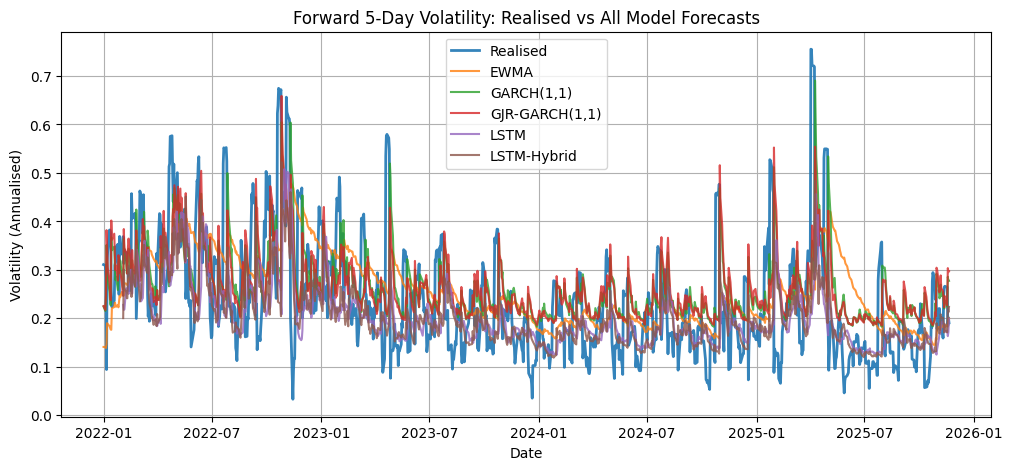

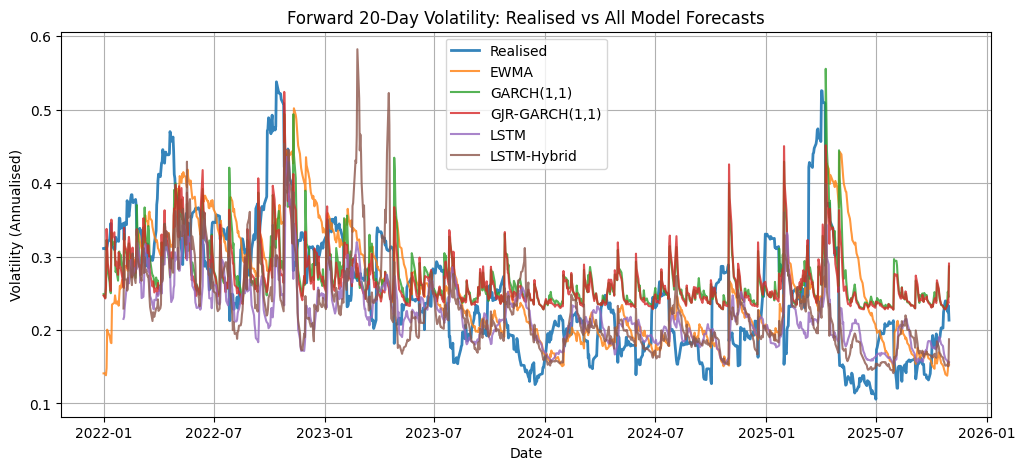

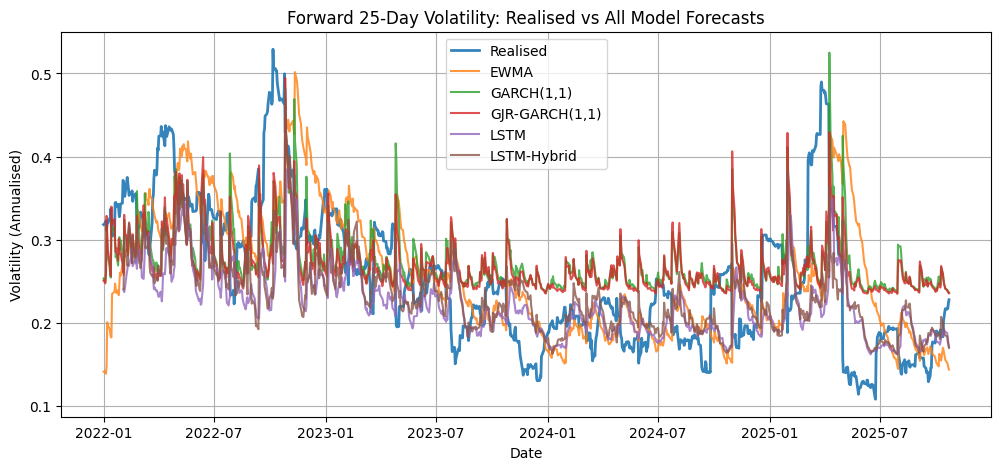

In [24]:
# ==========================
# 8.2 Combined plots for each horizon
# ==========================
for h in HORIZONS:
    curves = forecast_curves[h]
    realised = curves["Realised"]

    plt.figure(figsize=(12, 5))
    base_idx = realised.index

    # Realised variance
    plt.plot(base_idx, np.sqrt(252) * np.sqrt(realised["realized_var"]), label="Realised",
             linewidth=2, alpha=0.9)

    # EWMA / GARCH / GJR
    plt.plot(base_idx, np.sqrt(252) * np.sqrt(curves["EWMA"]["forecast_var"].reindex(base_idx)),
             label="EWMA", alpha=0.8)
    plt.plot(base_idx, np.sqrt(252) * np.sqrt(curves["GARCH"]["forecast_var"].reindex(base_idx)),
             label="GARCH(1,1)", alpha=0.8)
    plt.plot(base_idx, np.sqrt(252) * np.sqrt(curves["GJR"]["forecast_var"].reindex(base_idx)),
             label="GJR-GARCH(1,1)", alpha=0.8)

    # LSTM (if available)
    if curves["LSTM"] is not None:
        plt.plot(base_idx, np.sqrt(252) * np.sqrt(curves["LSTM"]["forecast_var"].reindex(base_idx)),
                 label="LSTM", alpha=0.8)

    # Hybrid (if available)
    if curves["LSTM_hybrid"] is not None:
        plt.plot(base_idx, np.sqrt(252) * np.sqrt(curves["LSTM_hybrid"]["forecast_var"].reindex(base_idx)),
                 label="LSTM-Hybrid", alpha=0.8)

    plt.title(f"Forward {h}-Day Volatility: Realised vs All Model Forecasts")
    plt.xlabel("Date")
    plt.ylabel("Volatility (Annualised)")
    plt.legend()
    plt.grid(True)
    # plt.close()
    plt.show()


### 8.3 Individual plots: realised vs each model

For diagnostic purposes, it is also useful to view each model **individually**
against realised variance. The next cell produces, for each horizon and each model,
a separate plot of realised forward variance and that model’s forecast.


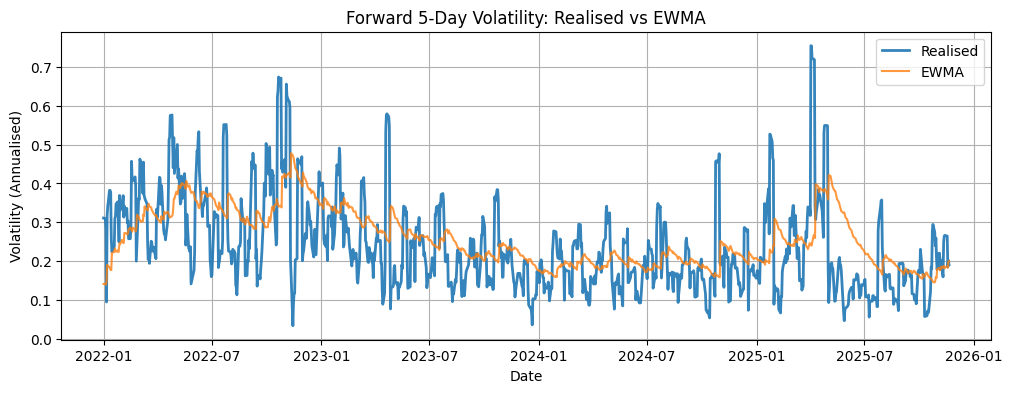

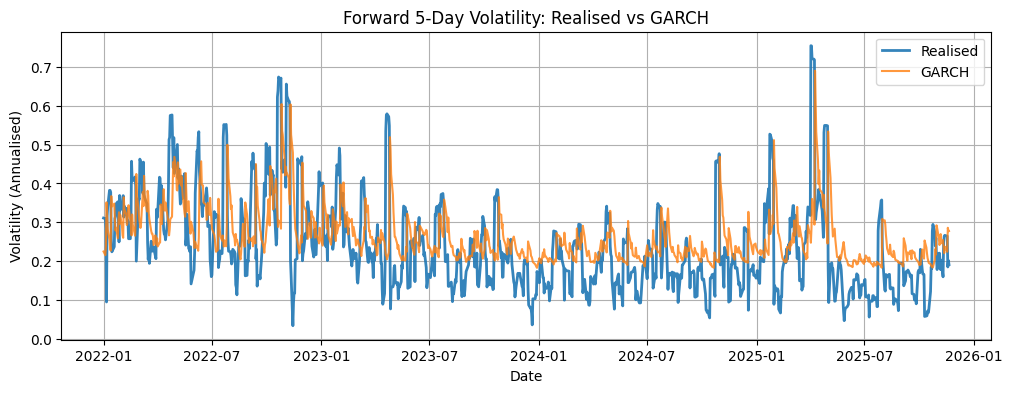

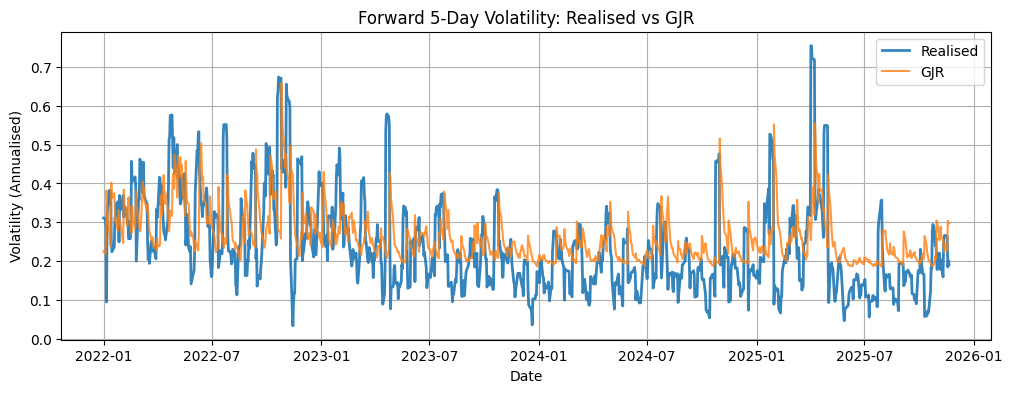

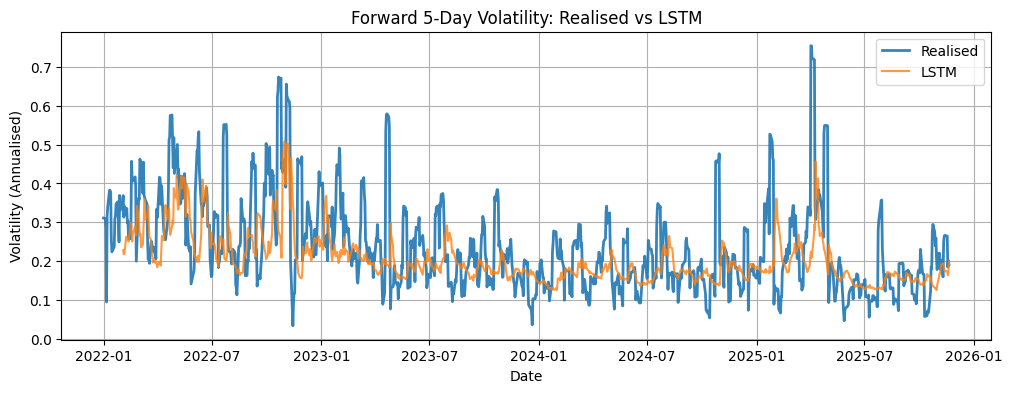

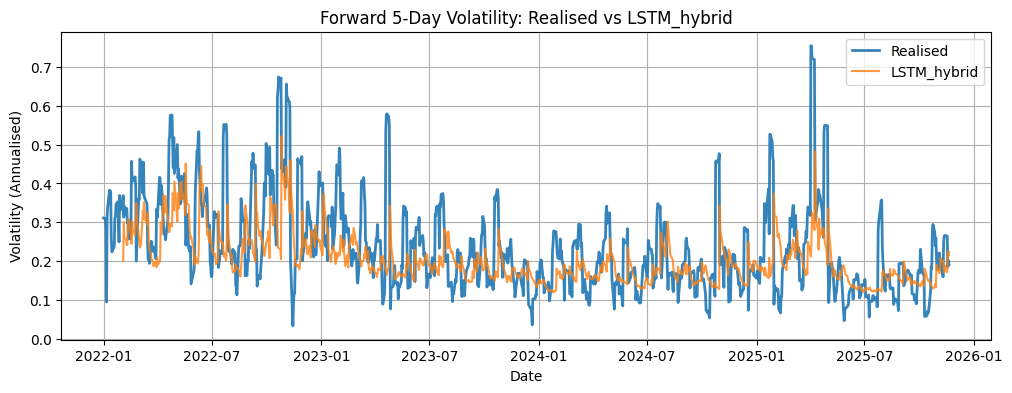

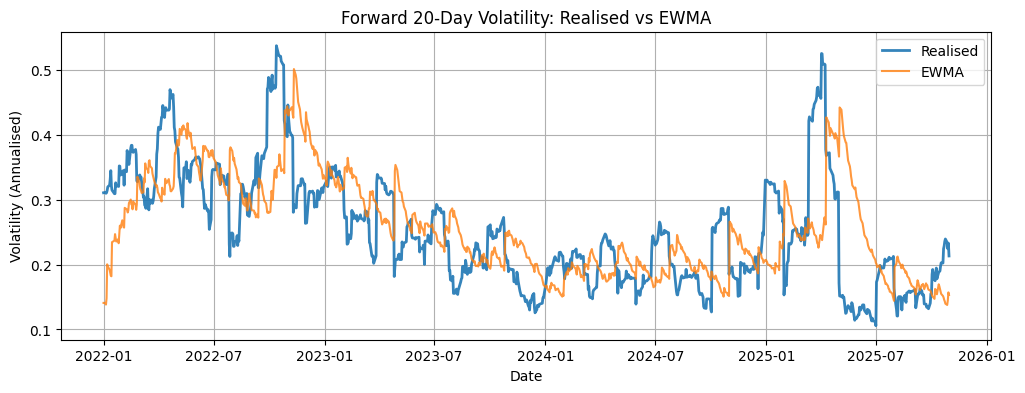

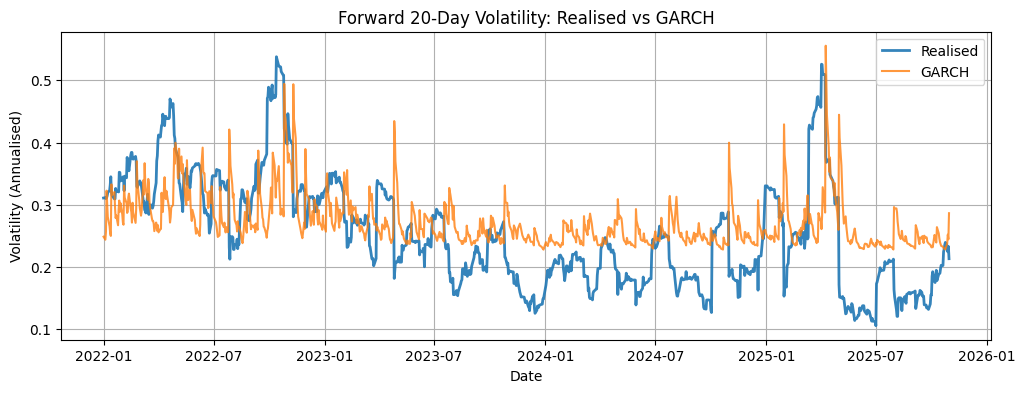

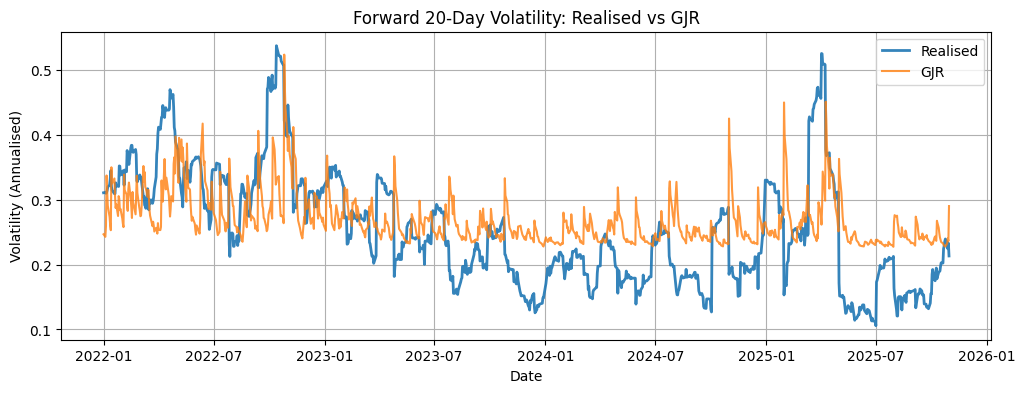

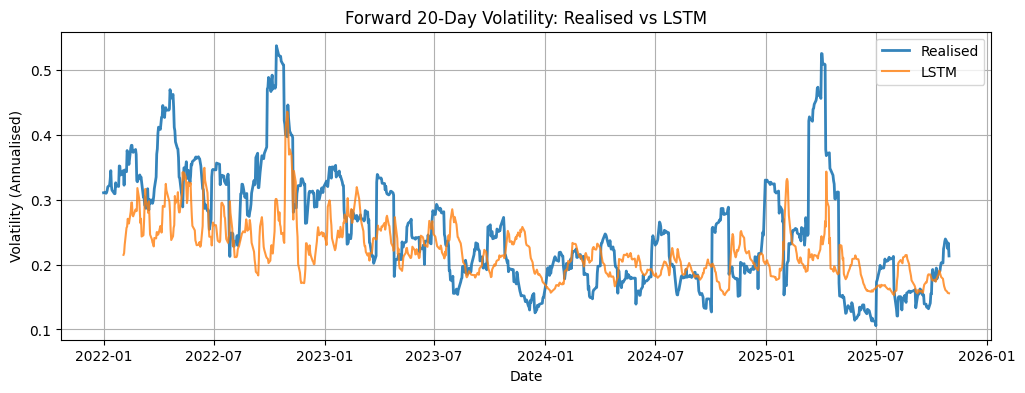

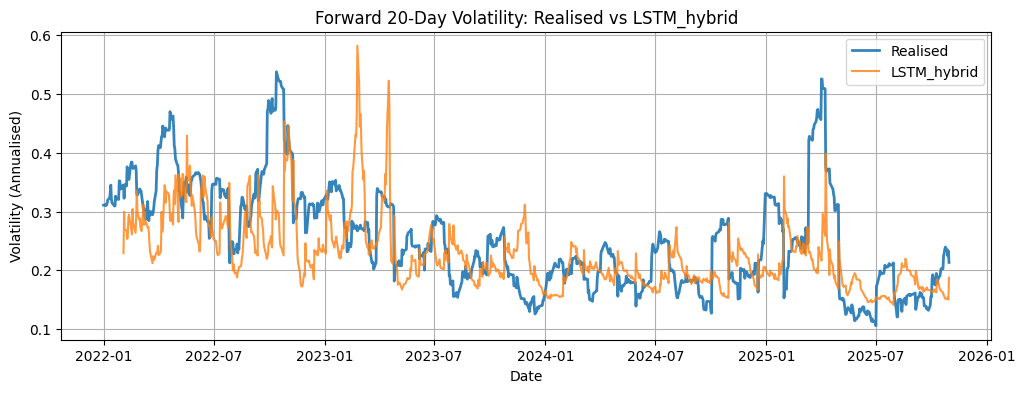

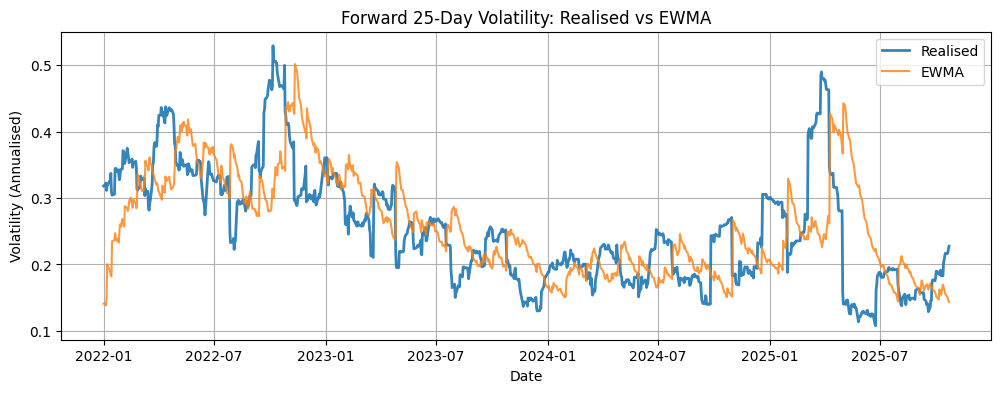

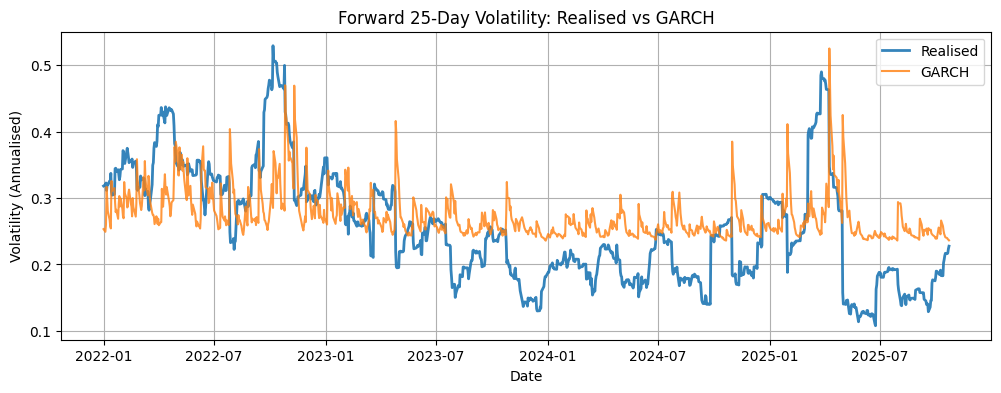

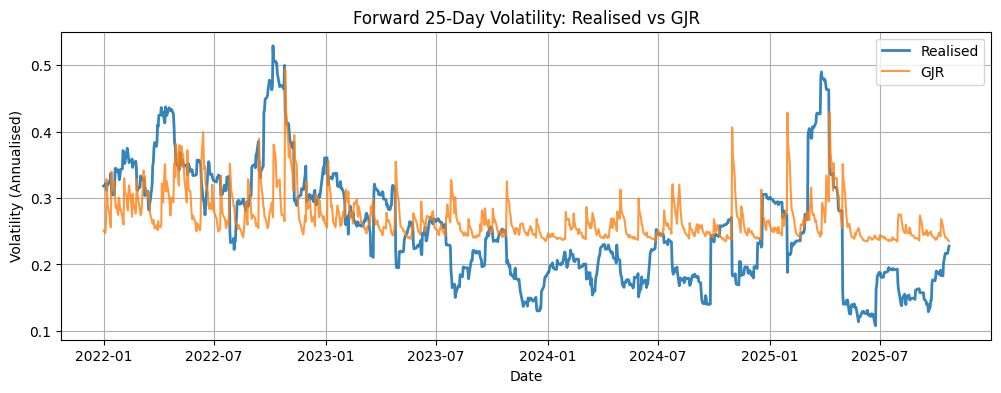

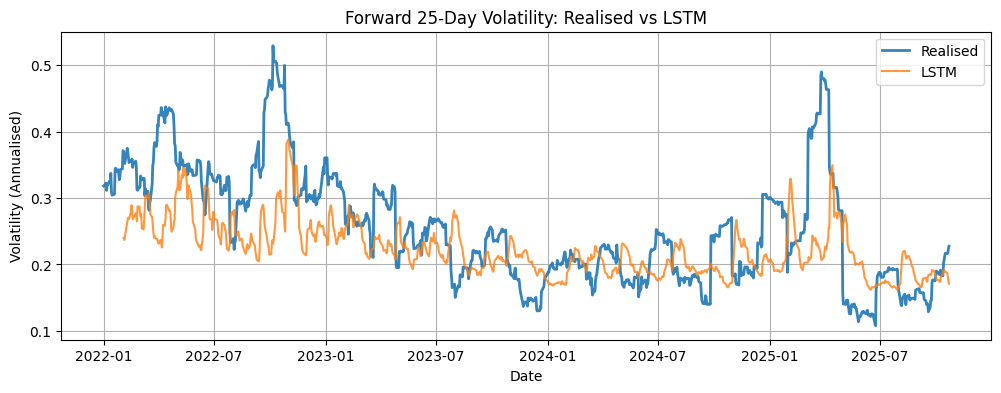

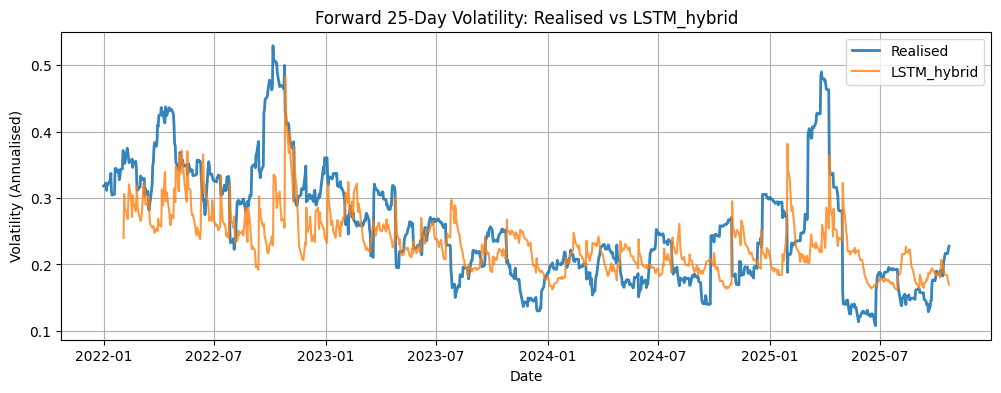

In [25]:
# ==========================
# 8.3 Individual plots: realised vs each model
# ==========================
model_order = ["EWMA", "GARCH", "GJR", "LSTM", "LSTM_hybrid"]

for h in HORIZONS:
    curves = forecast_curves[h]
    realised = curves["Realised"]
    base_idx = realised.index

    for model_name in model_order:
        model_df = curves.get(model_name)
        if model_df is None:
            continue  # skip models that were not estimated

        plt.figure(figsize=(12, 4))
        plt.plot(base_idx, np.sqrt(252) * np.sqrt(realised["realized_var"]), label="Realised",
                 linewidth=2, alpha=0.9)
        plt.plot(base_idx, np.sqrt(252) * np.sqrt(model_df["forecast_var"].reindex(base_idx)),
                 label=model_name, alpha=0.8)

        plt.title(f"Forward {h}-Day Volatility: Realised vs {model_name}")
        plt.xlabel("Date")
        plt.ylabel("Volatility (Annualised)")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"Forward_{h}_Day_Volatility_Realised_vs_{model_name}.png")
        # plt.close()
        plt.show()


### 8.4 QLIKE summary table

We now display the out-of-sample QLIKE loss for each model and horizon.
Lower values indicate better volatility forecasts.

In [26]:
# ==========================
# 8.4 Show QLIKE summary table
# ==========================
print(results_qlike.round(6))

        EWMA     GARCH       GJR      LSTM  LSTM_hybrid
5   0.422175  0.424183  0.424961  0.582796     0.584198
20  0.204881  0.195754  0.192196  0.249378     0.242531
25  0.186642  0.181448  0.177114  0.205000     0.188097


In [27]:
# ==========================
# 8.4 Show Relative Performance Table
# ==========================

benchmark_col = "GJR"
relative_performance = pd.DataFrame(index=results_qlike.index)

for col in results_qlike.columns:
    if col == benchmark_col:
        continue
    
    diff = (results_qlike[col] - results_qlike[benchmark_col]) / results_qlike[benchmark_col]
    relative_performance[f"{col} vs GJR"] = diff

print("\nRelative Performance vs GJR-GARCH")

print(relative_performance.round(2))

avg_deterioration = relative_performance.mean()

print("\nAverage Deterioration across all horizons")
print(avg_deterioration.round(2))


Relative Performance vs GJR-GARCH
    EWMA vs GJR  GARCH vs GJR  LSTM vs GJR  LSTM_hybrid vs GJR
5         -0.01         -0.00         0.37                0.37
20         0.07          0.02         0.30                0.26
25         0.05          0.02         0.16                0.06

Average Deterioration across all horizons
EWMA vs GJR           0.04
GARCH vs GJR          0.01
LSTM vs GJR           0.28
LSTM_hybrid vs GJR    0.23
dtype: float64


### 8.5 QLIKE Summary Table and Interpretation

The DataFrame `results_qlike` reports the out-of-sample QLIKE loss for each model and each horizon.
By construction, **lower QLIKE indicates better volatility forecasts**.

**Key Observations:**

1. **GARCH models dominate across all horizons and comparisons**: The leverage effect captured by the asymmetric term in GJR-GARCH also provides consistent forecasting improvements for longer horizons. However, we note the EWMA does slightly outperform GARCH models in the 5-day forecast.

2. **LSTM underperforms traditional models**: Both the LSTM and hybrid LSTM architectures fail to outperform GJR-GARCH(1,1,1). This is particularly evident at the 5-day horizon, where, in relative terms, the LSTM and Hybrid LSTM QLIKE (0.5828, 0.5842) is substantially worse than GJR-GARCH (0.4250).

3. **Hybrid approach does not improve upon GJR-GARCH**: Despite incorporating GJR-GARCH forecasts as features, the LSTM adjustment mechanism degrades rather than improves performance.

4. **Performance gap narrows as horizon increases**: While GJR-GARCH remains superior, the LSTM models show  better (though still inferior) relative performance at a 25-day horizon compared to their 5-day and 20-day horizons relative performance (with the 20-day window being the second best in terms of relative performance).
